In [1]:
import os
import sys
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from functools import partial
from sklearn.metrics import confusion_matrix
from model import MInterface
from data import DInterface

# from mlib import *

> This notebook is an example for analyzing a kfold result. There is some mismatching with the main code since it's directly adapted from one of my project. Please refer to the code and modify accordingly.

In [2]:
net_path = r'lightning_logs/version_XX/checkpoints/XXXX.ckpt'

In [3]:
data_module_drone = DInterface(
                 dataset='standard_data',
                 batch_size=1,
                 data_dir=r'data/ref/val',
                 class_num=10,
                 train=False,
                 no_augment=True,
                 aug_prob=0.5,
                 mean_sen=[0.485, 0.456, 0.406],
                 std_sen=[0.229, 0.224, 0.225])

data_module.setup()
loader = data_module.val_dataloader()

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MInterface.load_from_checkpoint(net_path).to(device)
model = model.eval()

In [9]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

def plot_classification_report(trues, preds, names, valid_labels, 
                               title='Classification Report Plot', 
                               out_path=None, 
                               figsize=(14,10)):
    report = classification_report(trues,
                                preds,
                                labels=valid_labels,
                                target_names=names,
                                output_dict=True)

    f, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
    ax.set_title(title)
    if out_path is not None:
        plt.savefig(out_path)

def plot_confusion_matrix(trues, preds, names, 
                          title="Confusion Matrix Visualization", 
                          out_path=None, 
                          figsize=(10,7)):
    cm = confusion_matrix(trues, preds)
    df_cm = pd.DataFrame(cm, index = names,
                    columns = names)
    plt.figure(figsize=figsize)
    ax=sns.heatmap(df_cm, annot=True)
    ax.set_title(title)
    if out_path is not None:
        plt.savefig(out_path) #'confusion matrix of sr.png'

def vis_metrix(trues, preds, names, 
               valid_labels, 
               explore_type='f1-score', 
               title=None, 
               figsize=(10,7)):
    report = classification_report(trues,
                                   preds,
                                   labels=valid_labels,
                                   target_names=names,
                                   output_dict=True)
    f1s = [report[name]['f1-score'] for name in target_names]
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.barplot(x=target_names, y=f1s, ax=ax)
    if title is None:
        title = f"{explore_type} Bar Plot"
    else:
        title = f"{explore_type} {title}"
    ax.set_title(title)
    plt.show()

def vis_melt_metrix(result_holder, names,
               valid_labels, 
               explore_type='f1-score', 
               title=None, 
               figsize=(10,7)):
    report_drone = classification_report(result_holder['trues'],
                                    result_holder['drone'],
                                    labels=valid_labels,
                                    target_names=names,
                                    output_dict=True)
    report_sr = classification_report(result_holder['trues'],
                                    result_holder['sr'],
                                    labels=valid_labels,
                                    target_names=names,
                                    output_dict=True)

    mcs_drone = [report_drone[name][explore_type] for name in target_names]
    mcs_sr = [report_sr[name][explore_type] for name in target_names]

    metrics_holder = {'class':target_names, 'Drone':mcs_drone, 'SR HSI': mcs_sr}

    df = pd.DataFrame(metrics_holder)
    df = pd.melt(df, id_vars="class", var_name="source", value_name=explore_type)
    fig, ax = plt.subplots(figsize=(10,7))
    sns.barplot(x='class', y=explore_type, hue='source', data=df, ax=ax)
    if title is None:
        title = f"{explore_type} Bar Plot"
    else:
        title = f"{explore_type} {title}"
    ax.set_title(title)
    plt.show()

def test_model(test_type='drone'):
    labels_list = []
    res_list = []
    loader = loader_sr if test_type == 'sr' else loader_drone
    model = model_sr if test_type == 'sr' else model_drone
    for data in loader:
        img, labels, filename = data
        img = img.to(device)
        out = model(img).cpu()
        label_digit = labels.argmax(axis=1)
        out_digit = out.argmax(axis=1)    
        correct_num = sum(label_digit==out_digit).cpu().item()
        labels_list.append(label_digit.item())
        res_list.append(out_digit.item())
        # break
    return labels_list, res_list

In [6]:
result_holder = {}

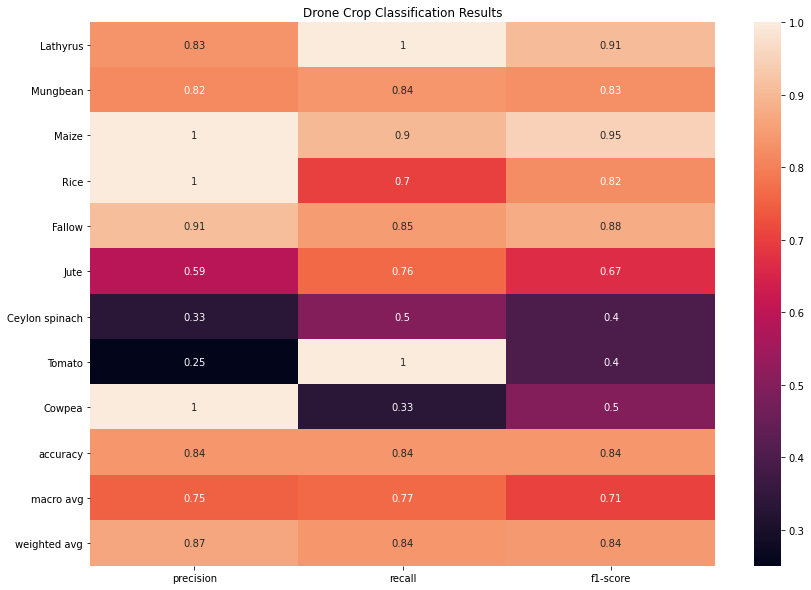

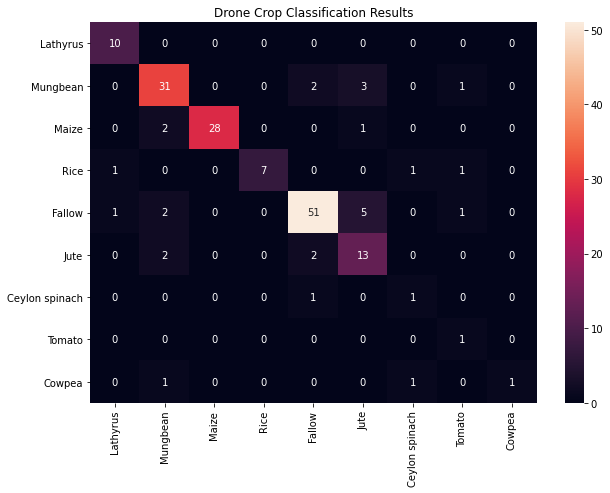

In [8]:
test_type = 'drone'
type_str = 'Drone' if test_type == 'drone' else 'SR HSI'

label_dict = mio.load('data/ref/9cls_crop_dict.pkl')
rev_dict = {v:k for k,v in label_dict.items()}

labels_list, res_list = test_model(test_type=test_type)
result_holder['trues']=labels_list
result_holder[test_type]=res_list

valid_labels = list(set(labels_list)|set(res_list))
target_names = [rev_dict[i] for i in valid_labels]

plot_classification_report(labels_list, res_list, target_names, valid_labels,#label_dict, 
                           title=f"{type_str} Crop Classification Results", 
                           out_path=f'results/{test_type}_result_report.png')
plot_confusion_matrix(labels_list, res_list, target_names, 
                      title=f"{type_str} Crop Classification Results", 
                      out_path=f'results/{test_type}_confusion_matrix.png')

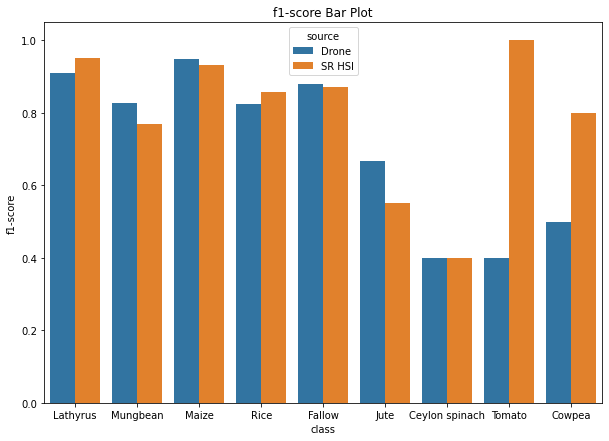

In [9]:
vis_melt_metrix(result_holder, target_names,
            valid_labels, 
            explore_type='f1-score', 
            title=None, 
            figsize=(10,7))

In [105]:
txt_report = classification_report(labels_list, drone_res_list)
print(txt_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.17      0.22      0.19        36
           4       0.36      0.43      0.39        23
           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         1
          10       0.42      0.60      0.49        62
          14       0.00      0.00      0.00        22
          17       0.00      0.00      0.00         4
          18       0.00      0.00      0.00         7
          19       0.00      0.00      0.00         2
          20       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         1

    accuracy                           0.31       180
   macro avg       0.06      0.08      0.07       180
weighted avg       0.22   

In [10]:
from collections import Counter, OrderedDict
counts = Counter(labels_list)
counts_ordered = OrderedDict(sorted(counts.items(), key=lambda kv: kv[1], reverse=True))
print(counts_ordered)

OrderedDict([(4, 60), (1, 37), (2, 31), (5, 17), (3, 10), (0, 10), (8, 3), (6, 2), (7, 1)])


# KFold

In [4]:
kfold=5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
def test_model_fold(loader, model, test_type):
    labels_list = []
    res_list = []
    for data in loader:
        img, labels, filename = data
        img = img.to(device)
        out = model(img).cpu()
        label_digit = labels.argmax(axis=1)
        out_digit = out.argmax(axis=1)    
        correct_num = sum(label_digit==out_digit).cpu().item()
        labels_list.append(label_digit.item())
        res_list.append(out_digit.item())
    return labels_list, res_list

In [6]:
def kfold_test(test_type='sr'):
    means = [0.485, 0.456, 0.406]
    stds  = [0.229, 0.224, 0.225]
    log_root = f'kfold_log/{test_type}'
    type_str = 'Drone' if test_type == 'drone' else 'SR HSI'
    model_paths = [glob.glob(op.join(log_root, f'version_{i}', 'checkpoints', 'best*'))[0] for i in range(5)]

    labels_list_total = []
    res_list_total = []
    for fold_idx in range(5):
        data_module = DInterface(
                        dataset='standard_data',
                        batch_size=1,
                        data_dir=r'data/ref/val',
                        class_num=10,
                        train=False,
                        no_augment=True,
                        aug_prob=0.5,
                        mean_sen=means,
                        std_sen=stds,
                        kfold=5,
                        fold_num=fold_idx)
        
        data_module.setup()
        loader = data_module.val_dataloader()
        model = MInterface.load_from_checkpoint(model_paths[fold_idx]).to(device)
        model = model.eval()
        labels_list, res_list = test_model_fold(loader, model, test_type)
        labels_list_total.extend(labels_list)
        res_list_total.extend(res_list)
    return labels_list_total, res_list_total

In [7]:
result_holder = {}

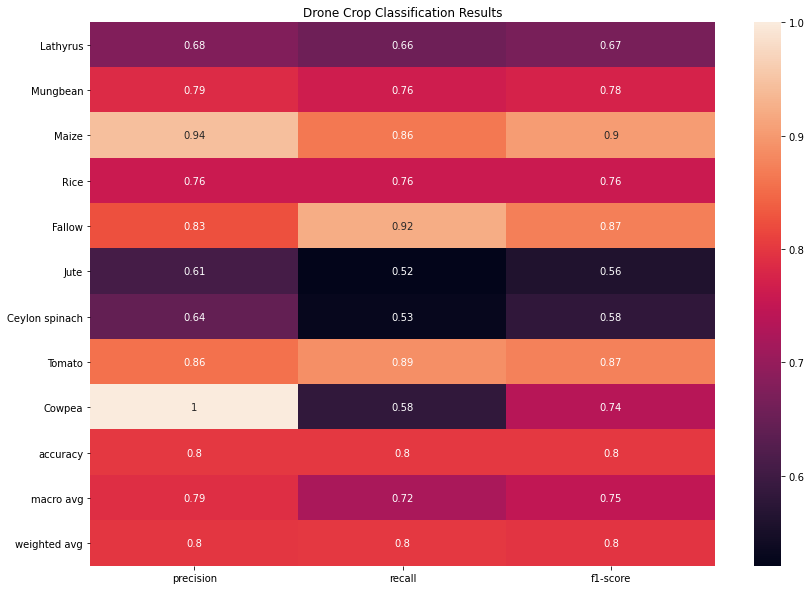

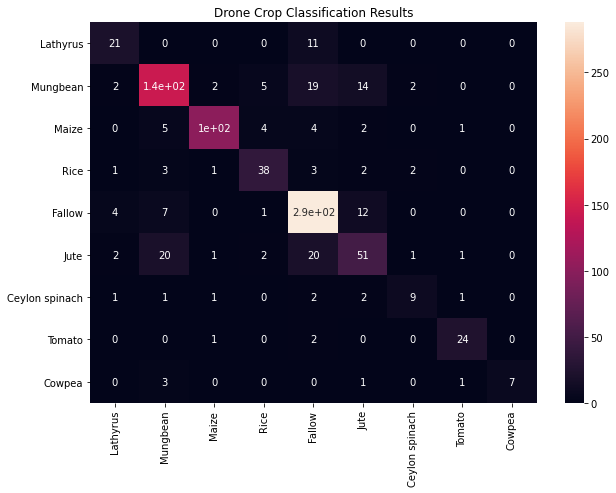

In [11]:
test_type = 'drone'
type_str = 'Drone' if test_type == 'drone' else 'SR HSI'

label_dict = mio.load('data/ref/9cls_crop_dict.pkl')
rev_dict = {v:k for k,v in label_dict.items()}

labels_list, res_list = kfold_test(test_type=test_type)
result_holder['trues']=labels_list
result_holder[test_type]=res_list

valid_labels = list(set(labels_list)|set(res_list))
target_names = [rev_dict[i] for i in valid_labels]

plot_classification_report(labels_list, res_list, target_names, valid_labels,#label_dict, 
                           title=f"results/{type_str} Crop Classification Results", 
                           out_path=f'{test_type}_result_report.png')
plot_confusion_matrix(labels_list, res_list, target_names, 
                      title=f"{type_str} Crop Classification Results", 
                      out_path=f'results/{test_type}_confusion_matrix.png')